In [3]:
#Importing libraries
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

#**Q1:**

I'm using below architecture for Object Recognition with CNNs:
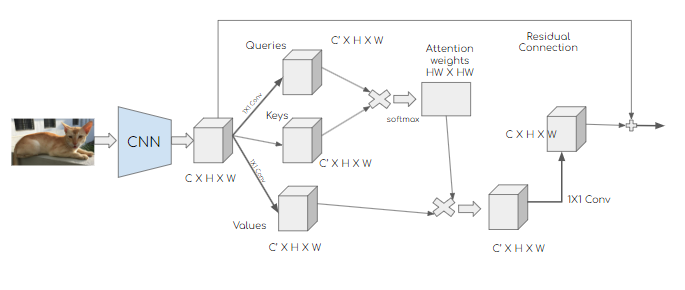

In [4]:
#Self-Attention for Object Recognition with CNNs
class Self_Attention(nn.Module):
    def __init__(self):
        super(Self_Attention, self).__init__()
        # Defining CNN layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3)

        #Fully connected layers
        self.fully_connected1 = nn.Linear(128, 64)
        self.fully_connected2 = nn.Linear(64, 32)
        self.fully_connected3 = nn.Linear(32, 10)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout(0.3)

        #Defining layer for Query, Key and Values
        self.Q_conv = nn.Conv2d(128, 128, kernel_size=1)
        self.K_conv = nn.Conv2d(128, 128, kernel_size=1)
        self.V_conv = nn.Conv2d(128, 128, kernel_size=1)

    def forward(self, img):

        #Passing images through CNN
        conv_output = func.relu(self.conv1(img))
        conv_output = func.relu(self.conv2(conv_output))
        conv_output = self.max_pool(conv_output)
        conv_output = func.relu(self.conv3(conv_output))
        conv_output = self.dropout(conv_output)
        conv_output = func.relu(self.conv4(conv_output))
        conv_output = self.max_pool(conv_output)
        conv_output = func.relu(self.conv5(conv_output))
        # print("Conv output",conv_output.shape)

        #Creating query, key and value
        queries = self.Q_conv(conv_output)
        keys = self.K_conv(conv_output)
        values = self.V_conv(conv_output)
        # print("Conv output",conv_output.shape)
        # print("Queries", queries.shape)
        # print("keys", keys.shape)
        # print("values", values.shape)

        #Calculating attentions
        attentions = func.softmax(torch.matmul(queries, keys.transpose(2, 3)) / torch.sqrt(torch.tensor(queries.size(-1))), dim=-1)
        # print(attentions.shape)
        # print(values.shape)
        attentions = torch.matmul(attentions, values)

        op = conv_output + self.gamma * attentions
        op = self.global_avg_pool(op)

        # print("op",op.shape)

        #Flattening
        op = op.view(-1, 128)
        # print("op",op.shape)

        #Passing through MLP
        op = func.relu(self.fully_connected1(op))
        op = func.relu(self.fully_connected2(op))
        op = func.relu(self.fully_connected3(op))

        return op


In [5]:
transformer = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
#Downloading and loading data
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformer)
train_data = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformer)
test_data = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:01<00:00, 94586234.75it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
#Training model
def train(cifar, train_data, epochs=3):
    loss_function = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.002)
    optimizer = optim.Adam(cifar.parameters(), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data, 0):
            inputs, y = data
            optimizer.zero_grad()
            #Feed forward
            pred = cifar(inputs)
            #Calculating Loss
            loss = loss_function(pred, y)
            #Backpropogation
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:
                print('Epoch: %d, data: %d loss: %.5f' % (epoch + 1, i , running_loss / 1000))
                running_loss = 0.0


In [10]:
#Creating model
Cifar_self = Self_Attention()
train(Cifar_self, train_data)

Epoch: 1, data: 999 loss: 2.23101
Epoch: 1, data: 1999 loss: 2.16833
Epoch: 1, data: 2999 loss: 2.11752
Epoch: 1, data: 3999 loss: 2.10268
Epoch: 1, data: 4999 loss: 2.07195
Epoch: 1, data: 5999 loss: 2.03745
Epoch: 1, data: 6999 loss: 2.03612
Epoch: 1, data: 7999 loss: 1.99978
Epoch: 1, data: 8999 loss: 2.00700
Epoch: 1, data: 9999 loss: 1.97754
Epoch: 1, data: 10999 loss: 1.88439
Epoch: 1, data: 11999 loss: 1.81448
Epoch: 2, data: 999 loss: 1.75384
Epoch: 2, data: 1999 loss: 1.75063
Epoch: 2, data: 2999 loss: 1.74292
Epoch: 2, data: 3999 loss: 1.69955
Epoch: 2, data: 4999 loss: 1.71960
Epoch: 2, data: 5999 loss: 1.67157
Epoch: 2, data: 6999 loss: 1.65087
Epoch: 2, data: 7999 loss: 1.64609
Epoch: 2, data: 8999 loss: 1.62569
Epoch: 2, data: 9999 loss: 1.58825
Epoch: 2, data: 10999 loss: 1.58398
Epoch: 2, data: 11999 loss: 1.56705
Epoch: 3, data: 999 loss: 1.52263
Epoch: 3, data: 1999 loss: 1.52756
Epoch: 3, data: 2999 loss: 1.49135
Epoch: 3, data: 3999 loss: 1.50568
Epoch: 3, data: 499

In [16]:
def test(model, test_data):
    corr = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, y = data
            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)
            total += y.size(0)
            corr += (pred == y).sum().item()
    print('Accuracy: %d %%' % (100 * corr / total))

In [12]:
#Testing model
test(Cifar_self,test_data)

Accuracy: 51 %


#**Q2:**

Using this architecture for encoder only transformer

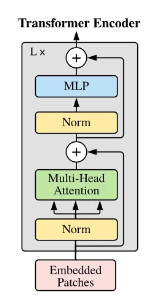

In [19]:
class Multi_Headed(nn.Module):
    def __init__(self, num_heads=4):
        super(Multi_Headed, self).__init__()
        # Defining CNN layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3)

        #Fully connected layers
        self.fully_connected1 = nn.Linear(51200, 64)
        self.fully_connected2 = nn.Linear(64, 32)
        self.fully_connected3 = nn.Linear(32, 64)
        self.fully_connected4 = nn.Linear(64, 128)

        self.fully_connected5 = nn.Linear(51200, 64)
        self.fully_connected6 = nn.Linear(64, 32)
        self.fully_connected7 = nn.Linear(32, 10)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.gamma1 = nn.Parameter(torch.zeros(1))
        self.gamma2 = nn.Parameter(torch.zeros(1))

        #Query, key and value will be divided into num_heads
        self.num_heads = num_heads

        self.Q = nn.Conv2d(128, 128, kernel_size=1)
        self.K = nn.Conv2d(128, 128, kernel_size=1)
        self.V = nn.Conv2d(128, 128, kernel_size=1)

        self.dropout = nn.Dropout(0.3)

        self.norm1 = nn.LayerNorm([128, 20, 20])
        self.norm2 = nn.LayerNorm([128, 20, 20])


    def forward(self, img):

        #Passing images through CNN (It is the same structure we used in Q1)
        conv_output = func.relu(self.conv1(img))
        conv_output = func.relu(self.conv2(conv_output))
        conv_output = self.max_pool(conv_output)
        conv_output = func.relu(self.conv3(conv_output))
        conv_output = self.dropout(conv_output)
        conv_output = func.relu(self.conv4(conv_output))
        conv_output = self.max_pool(conv_output)
        conv_output = func.relu(self.conv5(conv_output))
        # print("Conv output",conv_output.shape)
        conv_output_norm = self.norm1(conv_output)

        # print("conv_output_norm",conv_output_norm.shape)
        queries = self.Q(conv_output_norm)
        keys = self.K(conv_output_norm)
        values = self.V(conv_output_norm)
        # print(queries.shape)
        # print(queries.size(-3))

        #Dividing queries, keys and values
        queries = queries.view(queries.size(0), self.num_heads, queries.size(1)//self.num_heads, queries.size(2), queries.size(3))
        keys = keys.view(keys.size(0), self.num_heads, keys.size(1)//self.num_heads, keys.size(2), keys.size(3))
        values = values.view(queries.size(0), self.num_heads, values.size(1)//self.num_heads, values.size(2), values.size(3))

        #Calculating attentions
        attentions = []

        for i in range(self.num_heads):
            attention_weights = func.softmax(torch.matmul(queries[:, i], keys[:, i].transpose(2, 3)) / torch.sqrt(torch.tensor(queries.size(-1))), dim=-1)
            head_output = torch.matmul(attention_weights, values[:, i])
            attentions.append(head_output)

        # print("attentions",attentions)

        # Concatenate outputs from all heads
        multiheaded_attentions = torch.cat(attentions, dim=1)
        # print("attentions",multiheaded_attentions.shape)

        #Residual connection
        out_multi = conv_output + self.gamma1 * multiheaded_attentions
        # print("Conv output",conv_output.shape)
        # print("multiheaded",multiheaded_attentions.shape)
        op = self.norm2(out_multi)
        # print("op",op.shape)

        #Flattening
        # op = op.view(-1, 128)
        op = op.view(op.size(0), -1)
        # print("op",op.shape)

        #Passing through MLP
        op = func.relu(self.fully_connected1(op))
        op = func.relu(self.fully_connected2(op))
        op = self.dropout(op)
        op = func.relu(self.fully_connected3(op))
        op = func.relu(self.fully_connected4(op))

        op = op.unsqueeze(-1).unsqueeze(-1)
        # print("op after unsqueeze",op.shape)

        #Residual connection
        out = out_multi + self.gamma2 * op
        # print("out",out.shape)
        out = out.view(out.size(0), -1)

        #Passing through MLP for classification
        out = func.relu(self.fully_connected5(out))
        out = func.relu(self.fully_connected6(out))
        out = self.dropout(out)
        out = func.relu(self.fully_connected7(out))
        # print(out.shape)

        return out


In [24]:
#Creating model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar_transformer = Multi_Headed().to(device)

train(cifar_transformer, train_data,epochs=1)

Epoch: 1, data: 999 loss: 2.30182
Epoch: 1, data: 1999 loss: 2.30146
Epoch: 1, data: 2999 loss: 2.30449
Epoch: 1, data: 3999 loss: 2.30281
Epoch: 1, data: 4999 loss: 2.30304
Epoch: 1, data: 5999 loss: 2.30274
Epoch: 1, data: 6999 loss: 2.30257
Epoch: 1, data: 7999 loss: 2.30258
Epoch: 1, data: 8999 loss: 2.30262
Epoch: 1, data: 9999 loss: 2.30268
Epoch: 1, data: 10999 loss: 2.30437
Epoch: 1, data: 11999 loss: 2.30274


In [25]:
#Testing model
test(cifar_transformer,test_data)

Accuracy: 10 %


In [26]:
from torchsummary import summary
summary(Cifar_self, (3, 32, 32))
summary(cifar_transformer, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 27, 27]               0
            Conv2d-4           [-1, 32, 25, 25]           4,640
           Dropout-5           [-1, 32, 25, 25]               0
            Conv2d-6           [-1, 64, 23, 23]          18,496
         MaxPool2d-7           [-1, 64, 22, 22]               0
            Conv2d-8          [-1, 128, 20, 20]          73,856
            Conv2d-9          [-1, 128, 20, 20]          16,512
           Conv2d-10          [-1, 128, 20, 20]          16,512
           Conv2d-11          [-1, 128, 20, 20]          16,512
AdaptiveAvgPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                   [-1, 64]           8,256
           Linear-14                   

We can see that we are getting less accuracy in transformer based model than the self attention model

Losses were decreasing in self attention model but it is not decreasing in transformer based model
